# Finding Label Errors in Object Detection Datasets

This 5-minute quickstart tutorial demonstrates how to find potential label errors in object detection datasets. In object detection data, each image is annotated with multiple bounding boxes. Each bounding box surrounds a physical object within an image scene, and is annotated with a given class label. 

Using such labeled data, we train a model to predict the locations and classes of objects in an image. An example notebook to train the object detection model whose predictions we rely on in this tutorial is available [here](https://github.com/cleanlab/examples/blob/master/object_detection/detectron2_training.ipynb). These predictions can subsequently be input to cleanlab in order to identify mislabeled images and a quality score quantifying our confidence in the overall annotations for each image.  

After correcting these label issues, **you can train an even better version of your model without changing your training code!**

This tutorial uses a subset of the [COCO (Common Objects in Context)](https://cocodataset.org/#home) dataset which has images of everyday scenes and considers objects from the 5 most popular classes: car, chair, cup, person, traffic light.

**Overview of what we we'll do in this tutorial**

- Score images based on their overall label quality (i.e. our confidence each image is correctly labeled) using `cleanlab.object_detection.rank.get_label_quality_scores`
- Estimate which images have label issues using `cleanlab.object_detection.filter.find_label_issues`
- Visually review images + labels using `cleanlab.object_detection.summary.visualize`

<div class="alert alert-info">
Quickstart
<br/>
    
Already have `labels` and `predictions` in the proper format? Just run the code below to find label issues in your object detection dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import get_label_quality_scores

# To get boolean vector of label issues for all images
has_label_issue = find_label_issues(labels, predictions)

# To get label quality scores for all images
label_quality_scores = get_label_quality_scores(labels, predictions)
    
    
```

</div>
</div>

## 1. Install required dependencies and download data
You can use `pip` to install all packages required for this tutorial as follows
```ipython
!pip install matplotlib
!pip insall cleanlab
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    dependencies_test = [dependency.split('>')[0] if '>' in dependency 
                         else dependency.split('<')[0] if '<' in dependency 
                         else dependency.split('=')[0] for dependency in dependencies]
    missing_dependencies = []
    for dependency in dependencies_test:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
%%capture

!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/tutorial_obj/predictions.pkl'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/tutorial_obj/labels.pkl'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/tutorial_obj/example_images.zip' && unzip -q -o example_images.zip

In [3]:
import pickle
import numpy as np
from cleanlab.internal.object_detection_utils import calculate_bounding_box_areas
from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import (
    _separate_label,
    _separate_prediction,
    get_label_quality_scores,
    issues_from_scores,
)
from cleanlab.object_detection.summary import (
    bounding_box_size_distribution,
    class_label_distribution,
    object_counts_per_image,
    visualize,
)

## 2. Format data, labels, and model predictions

We begin by loading `labels` and `predictions` for our dataset, which are the only inputs required to find label issues with cleanlab. Note that the predictions should be **out-of-sample**, which can be obtained for every image in a dataset via K-fold cross-validation. 

In a separate [example](https://github.com/cleanlab/examples) notebook ([link](https://github.com/cleanlab/examples/blob/master/object_detection/detectron2_training.ipynb)), we trained a Detectron2 object detection model and used it to obtain predictions on a held-out validation dataset whose `labels` we audit here.

**Note:** If you want to find all the mislabeled images across the entire COCO dataset, you can first execute our [other example notebook](https://github.com/cleanlab/examples/blob/master/object_detection/detectron2_training-kfold.ipynb) that uses K-fold cross-validation to produce **out-of-sample** predictions for every image, then use those labels and predictions below.

In [4]:
IMAGE_PATH = './example_images/'  # path to raw image files downloaded above
predictions = pickle.load(open("predictions.pkl", "rb"))
labels = pickle.load(open("labels.pkl", "rb"))

In object detection datasets, each given label is a made up of bounding box coordinates and a class label. A model prediction is also made up of a bounding box and predicted class label, as well as the model confidence (probability estimate) in its prediction. To detect label issues, cleanlab requires given labels for each image, and the corresponding model predictions for the image (but not the image itself).

Here’s what an example looks like in our dataset. We visualize the given and predicted labels (in red and blue) for this image using the `cleanlab.object_detection.summary.visualize` method.

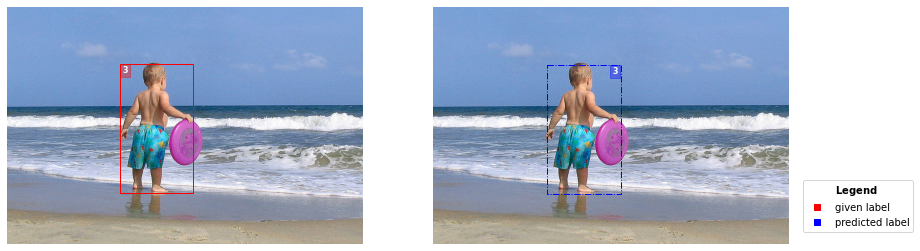

In [5]:
image_to_visualize = 8  # change this to view other images
image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
visualize(image_path, label=labels[image_to_visualize], prediction=predictions[image_to_visualize], overlay=False)

The required format of these `labels` and `predictions` matches what popular object detection frameworks like [MMDetection](https://github.com/open-mmlab/mmdetection) and [Detectron2](https://github.com/facebookresearch/detectron2/) expect. Recall the 5 possible class labels in our dataset are: car, chair, cup, person, traffic light. These classes are represented as (zero-indexed) integers 0,1,...,4.

`labels` is a list where for the i-th image in our dataset, `labels[i]` is a dictionary containing: key `labels` -- a list of class labels for each bounding box in this image and key `bboxes` -- a numpy array of the bounding boxes' coordinates. Each bounding box in `labels[i]['bboxes']` is in the format ``[x1,y1,x2,y2]`` format with respect to the image matrix where `(x1,y1)` corresponds to the top-left corner of the box and `(x2,y2)` the bottom-right (E.g. [XYXY in Keras](https://keras.io/api/keras_cv/bounding_box/formats/), [Detectron 2](https://detectron2.readthedocs.io/en/latest/modules/utils.html#detectron2.utils.visualizer.Visualizer.draw_box)).


Let's see what `labels[i]` looks like for our previous example image:

In [6]:
labels[image_to_visualize]

{'bboxes': array([[201.96, 101.71, 334.78, 334.68]], dtype=float32),
 'labels': array([3]),
 'bboxes_ignore': array([], shape=(0, 4), dtype=float32),
 'masks': [[[290.44,
    200.04,
    286.59,
    213.5,
    285.63,
    224.08,
    290.44,
    231.77,
    293.32,
    235.62,
    289.48,
    251.97,
    282.74,
    266.39,
    281.78,
    271.2,
    280.82,
    277.93,
    279.86,
    287.55,
    277.93,
    299.09,
    276.97,
    307.75,
    276.97,
    321.21,
    281.78,
    326.02,
    290.44,
    330.83,
    286.59,
    333.71,
    263.51,
    334.68,
    261.59,
    319.29,
    257.74,
    295.25,
    251.97,
    290.44,
    251.97,
    283.7,
    250.05,
    283.7,
    243.31,
    303.9,
    243.31,
    316.4,
    243.31,
    319.29,
    247.16,
    323.14,
    251.01,
    326.02,
    249.08,
    328.91,
    227.93,
    327.94,
    226.0,
    323.14,
    226.96,
    313.52,
    226.96,
    303.9,
    226.0,
    293.32,
    216.39,
    283.7,
    226.0,
    236.58,
    228.89,


`predictions` is a list where the predictions output by our model for the i-th image: `predictions[i]` is a list/array of shape `(K,)`. Here `K` is the number of classes in the dataset (same for every image) and `predictions[i][k]` is of shape `(M,5)`, where `M` is the number of bounding boxes predicted to contain objects of class `k` (in image i, differs between images). The five columns of `predictions[i][k]` correspond to ``[x1,y1,x2,y2,pred_prob]`` format with respect to the image matrix for each bounding box predicted by the model. Here `(x1,y1)` corresponds to the top-left corner of the box and `(x2,y2)` the bottom-right (E.g. [XYXY in Keras](https://keras.io/api/keras_cv/bounding_box/formats/), [Detectron 2](https://detectron2.readthedocs.io/en/latest/modules/utils.html#detectron2.utils.visualizer.Visualizer.draw_box)). The last column, `pred_prob` is the model confidence in its predicted label of class `k` for this box. Since our dataset has `K = 5` classes, we have: `predictions[i].shape = (5,)`.

Let's see what `predictions[i]` looks like for our previous example image:

In [7]:
predictions[image_to_visualize]

array([array([], shape=(0, 5), dtype=float32),
       array([], shape=(0, 5), dtype=float32),
       array([], shape=(0, 5), dtype=float32),
       array([[204.42398  , 103.44503  , 337.29968  , 336.21005  ,   0.9978472]],
             dtype=float32)                                                      ,
       array([], shape=(0, 5), dtype=float32)], dtype=object)


Once you have `labels` and `predictions` in the appropriate formats, you can **find label issues with cleanlab for any object detection dataset**!

## 3. Use cleanlab to find label issues
Given `labels` and `predictions` from our trained model, cleanlab can automatically find mislabeled images in the dataset. In object detection, we consider an image mislabeled if **any** of its bounding boxes or their class labels are incorrect (including if the image contains any overlooked objects which should've been annotated with a box)

Images may be mislabeled because annotators:

- overlooked an object (forgot to annotate a bounding box around a depicted object)
- chose the wrong class label for an annotated box in the correct location
- imperfectly drew the bounding box such that its location is incorrect


Cleanlab is expected to flag images that exhibit **any** of these annotation errors as having label issues. More severe annotation errors are expected to produce lower cleanlab label quality scores closer to 0. Let's first estimate which images have label issues:

In [8]:
label_issue_idx = find_label_issues(labels, predictions, return_indices_ranked_by_score=True)

num_examples_to_show = 5 # view this many images flagged with the most severe label issues
label_issue_idx[:num_examples_to_show]

Pruning 0 predictions out of 138 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.


array([50, 16, 31, 29, 45])

The above code identifies *which* images have label issues, returning a list of their indices. This is because we specified the `return_indices_ranked_by_score` argument which sorts these indices by the estimated label quality of each image. Below we describe how to directly estimate the label quality scores of each image.

**Note:** You can omit the `return_indices_ranked_by_score` argument for `find_label_issues()` to instead return a Boolean mask for the entire dataset (True entries in this mask correspond to images with label issues)

### Get label quality scores
Cleanlab can also compute scores for each image to estimate our confidence that it has been correctly labeled. These label quality scores range between 0 and 1, with *smaller* values indicating examples whose annotation is *more* likely to be wrong in some way.

Each image in the dataset receives a label quality score. These scores are useful for prioritizing which images to review; if you have too little time, first review the images with the lowest label quality scores.

In [9]:
scores = get_label_quality_scores(labels, predictions)
scores[:num_examples_to_show]

Pruning 0 predictions out of 138 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.


array([0.97489622, 0.70610878, 0.98764951, 0.88899237, 0.99085805])

We can also use the label quality scores to flag *which* images have label issues based on a threshold. Here we convert these per-image scores into an array of indices corresponding to images flagged with label issues, sorted by label quality score, in the same format returned by `find_label_issues()`

In [10]:
issue_idx = issues_from_scores(scores, threshold=0.5)  # lower threshold will return fewer (but more confident) label issues
issue_idx[:num_examples_to_show], scores[issue_idx][:num_examples_to_show]

(array([50, 16, 31, 29, 45]),
 array([6.95569726e-05, 9.03354841e-05, 8.57510169e-04, 1.58447666e-03,
        2.39755858e-01]))

## 4. Use ObjectLab to visualize label issues
Finally, we can visualize images with potential label errors via cleanlab's `visualize()` function. To enhance the visualization, you can supply a `class_names` dictionary to include as a legend and turn off `overlay` to see the given and predicted labels side by side.

./example_images/000000009483.jpg | idx 50 | label quality score: 6.95569726168054e-05 | is issue: True


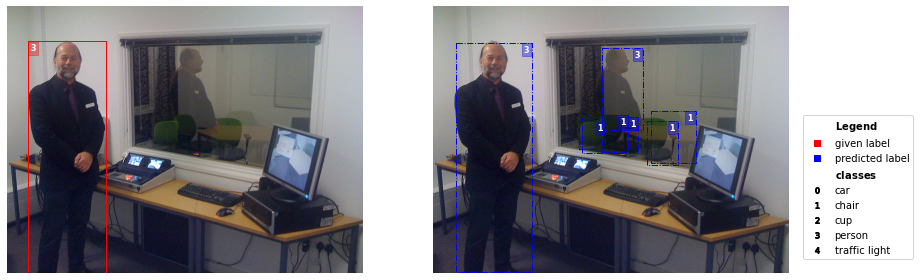

In [11]:
issue_to_visualize = issue_idx[0]  # change this to view other images
class_names = {"0": "car", "1": "chair", "2": "cup", "3":"person", "4": "traffic light"}

label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
score = scores[issue_to_visualize]
image_path = IMAGE_PATH + label['seg_map']

print(image_path, '| idx', issue_to_visualize , '| label quality score:', score, '| is issue: True')
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

The visualization depicts the given label (original image annotation which cleanlab identified as problematic) in red on the left and the model-predicted label in blue on the right. Each bounding box contains a class-index number in the top corner indicating which object class that bounding box was annotated/predicted to contain.

This image has a **low** label quality score and is marked as an error. On closer inspection we notice the annotator missed the reflection of the person in the mirror that the model identified. Additionally, the chairs visible in the reflection were not annotated.

Notice examples where the predictions and labels are more similar have higher quality scores than those that are missmatched, and are less likeley to be marked as issues and the number of boxes is agnostic to the score.

Better trained models will lead to better label error detection but you don't need a near perfect model to identify label issues.


### Different kinds of label issues identified by ObjectLab
Now lets view the first few images in our vaidation dataset that are clearly marked as issues and see what various inconsistencies between the `given` and `predicted` label we can spot. 

./example_images/000000395701.jpg | idx 16 | label quality score: 9.033548411774308e-05 | is issue: True


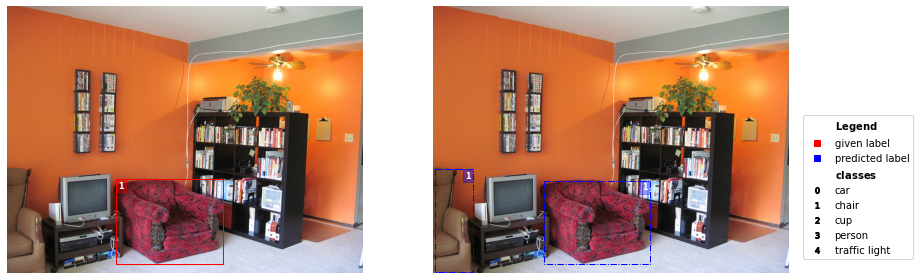

In [12]:
issue_to_visualize = issue_idx[1]
label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
score = scores[issue_to_visualize]

image_path = IMAGE_PATH + label['seg_map']
print(image_path, '| idx', issue_to_visualize , '| label quality score:', score, '| is issue: True')
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

Notice the armchair to the left of the TV is missing an annotation.

./example_images/000000242946.jpg | idx 46 | label quality score: 0.3300460146483339 | is issue: True


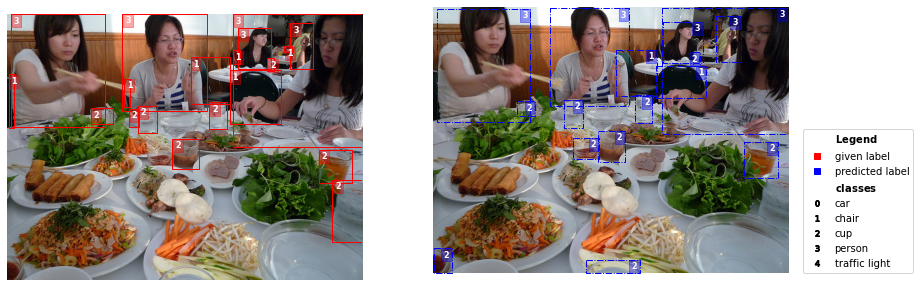

In [13]:
issue_to_visualize = issue_idx[6]
label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
score = scores[issue_to_visualize]

image_path = IMAGE_PATH + label['seg_map']
print(image_path, '| idx', issue_to_visualize , '| label quality score:', score, '| is issue: True')
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

Similarly, the woman in a red jacket in the foreground is missing an annotation.

./example_images/000000448410.jpg | idx 31 | label quality score: 0.0008575101690203273 | is issue: True


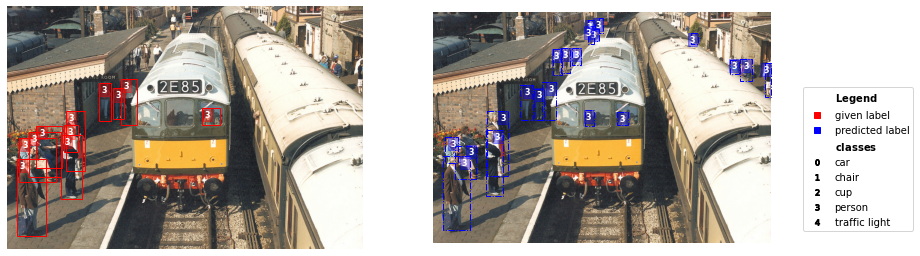

In [14]:
issue_to_visualize = issue_idx[2]
label = labels[issue_to_visualize]
prediction = predictions[issue_to_visualize]
score = scores[issue_to_visualize]

image_path = IMAGE_PATH + label['seg_map']
print(image_path, '| idx', issue_to_visualize , '| label quality score:', score, '| is issue: True')
visualize(image_path, label=label, prediction=prediction, class_names=class_names, overlay=False)

The people in this image should have had individual bounding boxes around each persons (the COCO guidelines state only groups with 10+ objects of the same type can be a \"crowd\" bounded by a single box). Individuals in the back are missing annotations.

All of these examples received low label quality scores reflecting their low annotation quality in the original dataset.

### Other uses of visualize
The `visualize()` function can also depict non-issue images, labels or predictions alone, or just the image itself. Let's explore this with a few images in our dataset.

We can save a visualization to file via the `save_path` argument. Note the label quality score is high for this example and it is marked as a non-issue. The given and predicted labels closely resemble each other contributing to the high score.

./example_images/000000499768.jpg | idx 0 | label quality score: 0.9748962231208227 | is issue: False


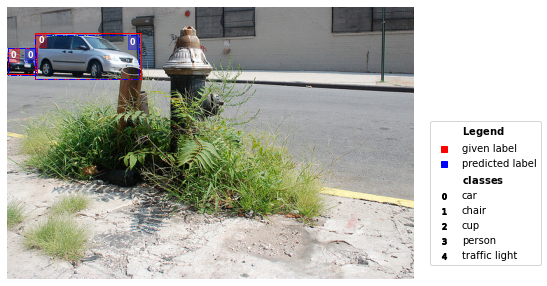

In [15]:
image_to_visualize = 0
image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
print(image_path, '| idx', image_to_visualize , '| label quality score:', scores[image_to_visualize], '| is issue:', image_to_visualize in issue_idx)
visualize(image_path, label=labels[image_to_visualize], prediction=predictions[image_to_visualize], class_names=class_names, save_path='./example_image.png')

For the next example, notice how we are only passing in the given labels to visualize. We can limit visualization to either labels, predictions, or neither.

./example_images/000000521141.jpg | idx 3 | label quality score: 0.8889923658893666 | is issue: False


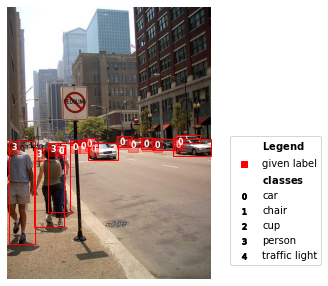

In [16]:
image_to_visualize = 3
image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
print(image_path, '| idx', image_to_visualize , '| label quality score:', scores[image_to_visualize], '| is issue:', image_to_visualize in issue_idx)
visualize(image_path, label=labels[image_to_visualize], class_names=class_names)

For completeness, let's just look at an image alone.

./example_images/000000143931.jpg | idx 2 | label quality score: 0.9876495074395956 | is issue: False


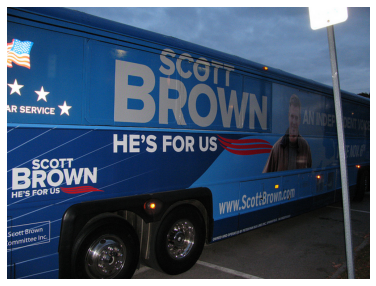

In [17]:
image_to_visualize = 2
image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
print(image_path, '| idx', image_to_visualize , '| label quality score:', scores[image_to_visualize], '| is issue:', image_to_visualize in issue_idx)
visualize(image_path)

## Exploratory data analysys

This section focuses on techniques to uncover annotation irregularities through exploratory data analysis. Specifically, it aims to highlight anomalies in object sizes, detect images with unusual object counts, and examine the distribution of class labels.

./example_images/000000430073.jpg | idx 100


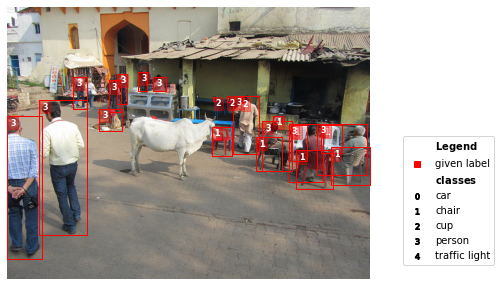

./example_images/000000183709.jpg | idx 102


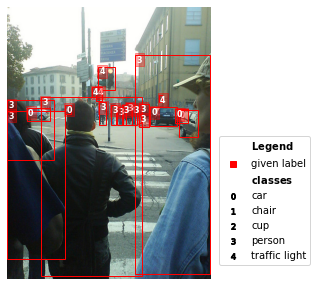

./example_images/000000189475.jpg | idx 101


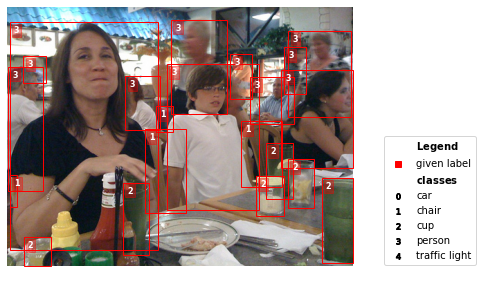

In [18]:
num_imgs_to_show = 3
lab_object_counts,pred_object_counts = object_counts_per_image(labels,predictions)
for image_to_visualize in np.argsort(lab_object_counts)[::-1][0:num_imgs_to_show]:
    image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
    print(image_path, '| idx', image_to_visualize)
    visualize(image_path, label=labels[image_to_visualize], class_names=class_names)

In [19]:
label_norm,pred_norm = class_label_distribution(labels,predictions)
print("Frequency of each class amongst annotated | predicted bounding boxes in the dataset:\n")
for i in label_norm:
    print(f"{class_names[str(i)]} : {label_norm[i]} | {pred_norm[i]}")

Frequency of each class amongst annotated | predicted bounding boxes in the dataset:

car : 0.08 | 0.06
person : 0.68 | 0.7
cup : 0.11 | 0.11
chair : 0.1 | 0.09
traffic light : 0.03 | 0.04


Here, anomalies in bounding box areas per class are assessed by calculating the maximum deviation from expected distributions based on mean and standard deviation statistics.

In [20]:
lab_area,pred_area = bounding_box_size_distribution(labels,predictions)
lab_area_mean = {i: np.mean(lab_area[i]) for i in lab_area.keys()}
lab_area_std = {i: np.std(lab_area[i]) for i in lab_area.keys()}

max_deviation_values = []
max_deviation_classes = []

for label in labels:
    bounding_boxes, label_names = _separate_label(label)
    areas = calculate_bounding_box_areas(bounding_boxes)
    deviation_values = []
    deviation_classes = []

    for class_name, mean_area, std_area in zip(lab_area_mean.keys(), lab_area_mean.values(), lab_area_std.values()):
        class_areas = areas[label_names == class_name]
        deviations_away = (class_areas - mean_area) / std_area
        deviation_values.extend(list(deviations_away))
        deviation_classes.extend([class_name] * len(class_areas))

    if deviation_values==[]:
        max_deviation_values.append(0.0)
        max_deviation_classes.append(-1)
    else:
        max_deviation_index = np.argmax(np.abs(deviation_values))
        max_deviation_values.append(deviation_values[max_deviation_index])
        max_deviation_classes.append(deviation_classes[max_deviation_index])

max_deviation_classes, max_deviation_values = np.array(max_deviation_classes), np.array(max_deviation_values)


./example_images/000000422886.jpg | idx 103 | class person


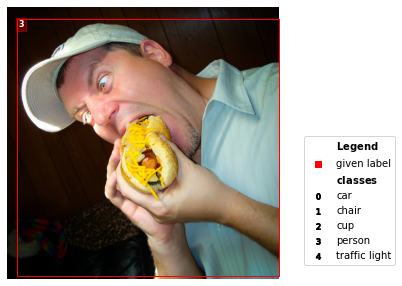

./example_images/000000341828.jpg | idx 104 | class person


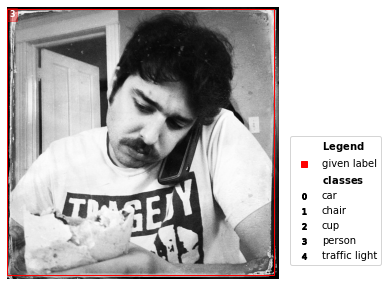

./example_images/000000461009.jpg | idx 105 | class person


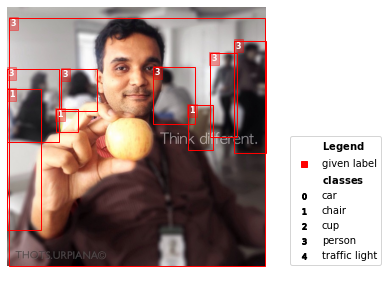

In [23]:
num_imgs_to_show_per_class = 3

for c in class_names.keys():
    class_num = int(c)
    sorted_indices = np.argsort(max_deviation_values)[::-1]
    count = 0

    for image_to_visualize in sorted_indices:
        if max_deviation_values[i] == 0 or max_deviation_classes[i] != class_num:
            continue
        image_path = IMAGE_PATH + labels[image_to_visualize]['seg_map']
        print(image_path, '| idx', image_to_visualize, '| class', class_names[c])
        visualize(image_path, label=labels[image_to_visualize], class_names=class_names)

        count += 1
        if count == num_imgs_to_show_per_class:
            break  # Break the loop after visualizing the top 3 instances for the current class


In [22]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
import numpy as np

assert 50 in issue_idx and issue_idx[0] == 50
assert 16 in issue_idx and issue_idx[1] == 16
assert 31 in issue_idx and issue_idx[2] == 31
assert 62 in issue_idx and issue_idx[9] == 62 

assert 2 not in issue_idx and 3 not in issue_idx and 0 not in issue_idx